# 1. Set-up

In [1]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMAGE_SIZE = [240, 240]
EPOCHS = 25

# 2. Load the data

In [2]:
filenames = tf.io.gfile.glob(str('chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str('chest_xray/val/*/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

In [3]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1081
Pneumonia images count in training set: 3104


In [4]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [5]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [6]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str("chest_xray/train/*"))])
CLASS_NAMES

array(['NORMAL', 'PNEUMONIA'], dtype='<U9')

In [7]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"

In [8]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [9]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [10]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (240, 240, 3)
Label:  False


In [12]:
test_list_ds = tf.data.Dataset.list_files(str('chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

TEST_IMAGE_COUNT

624

# 3. Visualize the dataset

In [13]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [14]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [15]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

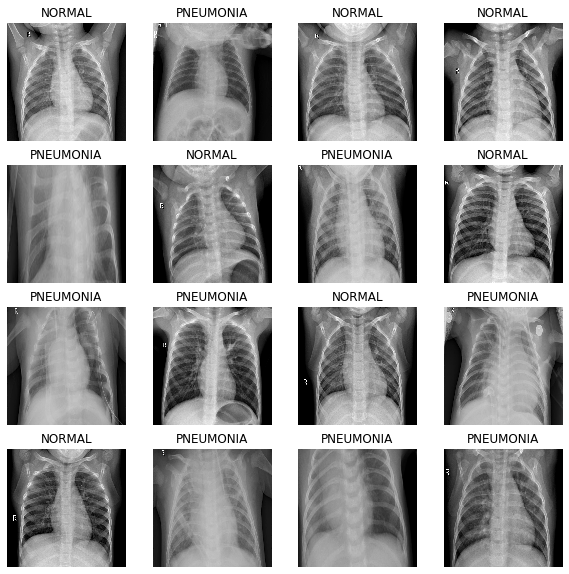

In [16]:
show_batch(image_batch.numpy(), label_batch.numpy())

# 4. Build the CNN

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# 5. Correct for data imbalance

In [26]:
initial_bias = np.log([COUNT_PNEUMONIA/COUNT_NORMAL])
initial_bias

array([1.05480506])

In [27]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


# 6. Train the model

In [29]:
model = build_model()
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [22]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [23]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [30]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=100,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
130/130 [==============================] - 88s 565ms/step - loss: 0.5726 - accuracy: 0.6993 - precision: 0.8853 - recall: 0.6830 - val_loss: 5.0285 - val_accuracy: 0.7422 - val_precision: 0.7422 - val_recall: 1.0000
Epoch 2/100
130/130 [==============================] - 63s 481ms/step - loss: 0.3125 - accuracy: 0.8724 - precision: 0.9524 - recall: 0.8711 - val_loss: 0.6728 - val_accuracy: 0.7539 - val_precision: 0.7794 - val_recall: 0.9330
Epoch 3/100
130/130 [==============================] - 63s 483ms/step - loss: 0.2195 - accuracy: 0.9161 - precision: 0.9695 - recall: 0.9159 - val_loss: 0.4399 - val_accuracy: 0.8145 - val_precision: 0.8019 - val_recall: 0.9961
Epoch 4/100
130/130 [==============================] - 63s 485ms/step - loss: 0.1808 - accuracy: 0.9356 - precision: 0.9760 - recall: 0.9362 - val_loss: 0.1496 - val_accuracy: 0.

130/130 [==============================] - 65s 500ms/step - loss: 0.0360 - accuracy: 0.9880 - precision: 0.9967 - recall: 0.9870 - val_loss: 0.0563 - val_accuracy: 0.9834 - val_precision: 0.9921 - val_recall: 0.9855
Epoch 36/100
130/130 [==============================] - 65s 501ms/step - loss: 0.0392 - accuracy: 0.9865 - precision: 0.9961 - recall: 0.9858 - val_loss: 0.0675 - val_accuracy: 0.9795 - val_precision: 0.9920 - val_recall: 0.9803
Epoch 37/100
130/130 [==============================] - 65s 501ms/step - loss: 0.0264 - accuracy: 0.9909 - precision: 0.9980 - recall: 0.9896 - val_loss: 0.0590 - val_accuracy: 0.9824 - val_precision: 0.9960 - val_recall: 0.9803
Epoch 38/100
130/130 [==============================] - 65s 501ms/step - loss: 0.0216 - accuracy: 0.9913 - precision: 0.9977 - recall: 0.9906 - val_loss: 0.0574 - val_accuracy: 0.9834 - val_precision: 0.9947 - val_recall: 0.9829
Epoch 39/100
130/130 [==============================] - 65s 499ms/step - loss: 0.0377 - accuracy:

# 7. Visualizing model performance

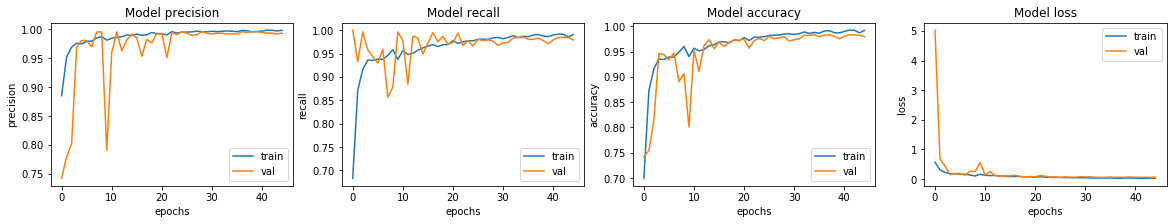

In [31]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# 8. Predict and evaluate results

In [102]:
loss, acc, prec, rec = model.evaluate(test_ds)

20/20 [==============================] - 4s 188ms/step - loss: 1.1042 - accuracy: 0.8029 - precision: 0.7633 - recall: 0.9923


# 9. Saliency Map

In [171]:
image_batch, label_batch = next(iter(test_ds))
single_image = tf.reshape(image_batch[0], [1,240,240,3])
label_batch

<tf.Tensor: shape=(32,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True, False, False,
       False, False,  True,  True, False,  True,  True,  True, False,
        True, False,  True, False,  True])>

In [172]:
layers = [layer.output for layer in model.layers]
images = tf.Variable(single_image, dtype=float)

with tf.GradientTape() as tape:
    y_pred = model(images)
    class_idxs_sorted = np.argsort(y_pred.numpy().flatten())[::-1]
    loss = y_pred[0][class_idxs_sorted[0]]
    
grads = tape.gradient(loss, images)
dgrad_abs = tf.math.abs(grads)
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

## normalize to range between 0 and 1
arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

[[0.99985766]]


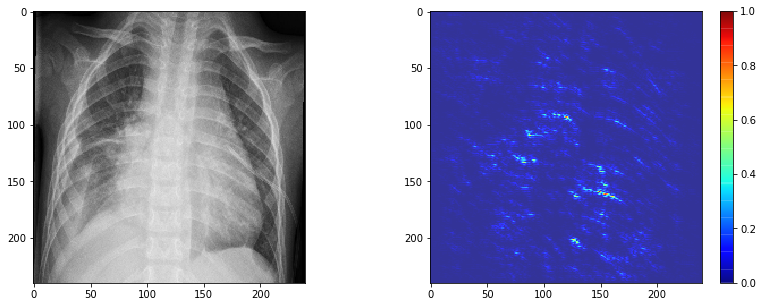

In [173]:
# Show results
print(model.predict(single_image))
fig, axes = plt.subplots(1,2,figsize=(14,5))
axes[0].imshow(image_batch[0])
i = axes[1].imshow(grad_eval,cmap="jet",alpha=0.8)
fig.colorbar(i)